In [28]:
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## Loading Dataset

In [29]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("Data_te_std.pkl")
Dataset_norm = pd.read_pickle("Data_te_norm.pkl") 
Attack_label = pd.read_pickle("Attack_label.pkl")
Attack_type = pd.read_pickle("Attack_type.pkl")

# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset_std.shape[0],Dataset_std.shape[0]/8 , random_state=22)
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])
Dataset_std_short = pd.DataFrame(Dataset_std.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])

# mapping for 6 class and then sampling
mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
temp = Attack_type.map(mapping_dict)
Attack_type_short = pd.DataFrame(temp.loc[indices.tolist()])

In [30]:
# Oversampling
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_std_short, Attack_type_short)
print(Attack_type_short.value_counts(normalize = True))
print(Target_res.value_counts(normalize = True))

Attack_type
1              0.315539
4              0.197769
5              0.194677
6              0.152091
2              0.132522
3              0.007402
Name: proportion, dtype: float64
Attack_type
2              0.215795
1              0.212508
5              0.190340
6              0.175108
3              0.112149
4              0.094100
Name: proportion, dtype: float64


In [31]:
# Train Test split
X = Dataset_res.to_numpy() 
Y = Target_res.to_numpy(dtype='int')
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.2, random_state=22) 
print("Train set: ", X_train.shape) 
print("Test set: ", X_test.shape) 

Train set:  (3834, 36)
Test set:  (15337, 36)


## Hyperparameter

In [44]:
# Validation set
X_val, X_temp, Y_val, Y_temp = train_test_split(X_test, Y_test, train_size=0.2, random_state=22) 
print("Validation set: ", X_val.shape) 

Validation set:  (3156, 36)


In [58]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC

param_grid = {'n_estimators':np.arange(20,100,20),
              'max_features':np.arange(0.1, 1, 0.2),
              'max_depth': [3, 5, 7, 9, 11],
              'max_samples': [0.3, 0.5, 0.8],
              'criterion': ['gini', 'entropy']}

model = GridSearchCV(RFC(), param_grid, cv=3).fit(X_val, Y_val)
print("Best parameters: ", model.best_params_)

Best parameters:  {'criterion': 'gini', 'max_depth': 11, 'max_features': 0.9000000000000001, 'max_samples': 0.8, 'n_estimators': 80}


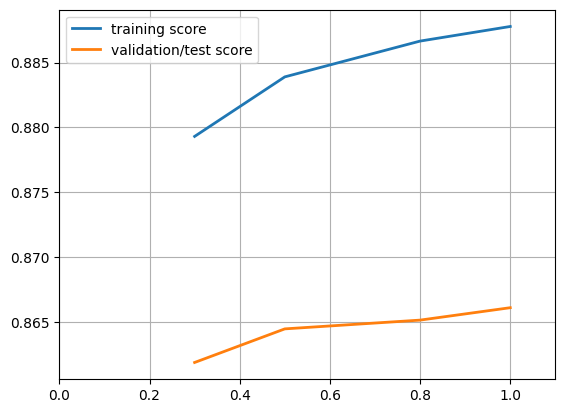

In [74]:
from sklearn.model_selection import validation_curve

sample_set = [0.3, 0.5, 0.8, 1.0]
train_score, test_score = validation_curve(RFC(n_estimators=80, max_features=0.9, max_depth=11, criterion='gini', random_state=22),
                                            X_train, Y_train, param_name= 'max_samples', param_range= sample_set, cv=3)

fig, ax = plt.subplots()
ax.grid()
ax.plot(sample_set, train_score.mean(axis=1), linewidth=2.0, label = 'training score')
ax.plot(sample_set, test_score.mean(axis=1), linewidth=2.0, label = 'validation/test score')
ax.set(xlim=(0, 1.1))
plt.legend()
plt.show()


## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=80, max_samples= 0.8, max_depth=11,
                             max_features= 0.9, criterion= 'gini', random_state=22, oob_score= True)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)

### Evaluation

In [39]:
print("Training Score: ", rfc.score(X_train, Y_train))
print("Test Score: ", rfc.score(X_test, Y_test))
print("Out of the Box Score: ", rfc.oob_score_)

Training Score:  0.9830464267083986
Test Score:  0.9738540783725631
Out of the Box Score:  0.9747000521648409


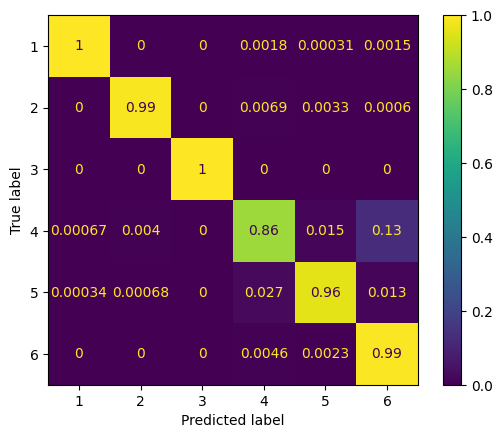

Average Accuracy: 0.9738540783725631
   Precision    Recall  F1-Score
1   0.999387  0.996335  0.997859
2   0.997562  0.989124  0.993325
3   1.000000  1.000000  1.000000
4   0.912950  0.855121  0.883090
5   0.985975  0.959072  0.972337
6   0.919071  0.993156  0.954678


In [40]:
from sklearn import metrics

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=rfc.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()
plt.show()

print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= rfc.classes_)
print(df_metric)

## Random Forest for 15 class Classification

 ### Data preperation

In [7]:
# mapping for 15 class and then sampling
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder().fit(Attack_type)
Attack_type_15 = LE.transform(Attack_type)
Attack_type_15 = pd.DataFrame(Attack_type_15)
Attack_type_15_short = pd.DataFrame(Attack_type_15.loc[indices.tolist()])

In [27]:
# Oversampling
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_std_short, Attack_type_15_short)
print("Proportion before Oversampling: ", Attack_type_15_short.value_counts(normalize = True, sort= False))
print("Proportion after Oversampling: ", Target_res.value_counts(normalize = True, sort= False))

Proportion before Oversampling:  0     0.062966
1     0.068188
2     0.088872
3     0.067630
4     0.090849
5     0.005627
6     0.007402
7     0.152091
8     0.061445
9     0.062814
10    0.070266
11    0.065349
12    0.064639
13    0.064081
14    0.067782
Name: proportion, dtype: float64
Proportion after Oversampling:  0     0.104708
1     0.047079
2     0.123200
3     0.079679
4     0.124028
5     0.083320
6     0.042363
7     0.047286
8     0.028587
9     0.064537
10    0.091883
11    0.029414
12    0.023167
13    0.089691
14    0.021057
Name: proportion, dtype: float64


In [11]:
from sklearn.model_selection import train_test_split

X = Dataset_res.to_numpy()
Y = Target_res.to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.4, random_state=22)  
X_val, X_temp, Y_val, Y_temp = train_test_split(X_test, Y_test, train_size=0.3, random_state=22) 
print("Train set: ", X_train.shape) 
print("Test set: ", X_test.shape)
print("Validation set: ", X_val.shape) 

Train set:  (9668, 36)
Test set:  (14504, 36)
Validation set:  (4351, 36)


### Hyperparameter

In [129]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC

param_grid = {'n_estimators':[50, 100, 150],
              'max_features':[0.5, 0.7, 0.8],
              'max_depth': [5, 9, 11],
              'max_samples': [0.5, 0.8],
              'criterion': ['gini', 'entropy']}

model = GridSearchCV(RFC(), param_grid, cv=2).fit(X_val, Y_val)
print("Best parameters: ", model.best_params_)

Best parameters:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 0.7, 'max_samples': 0.8, 'n_estimators': 100}


### The Modal

In [12]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, max_samples= 0.8, max_depth= 9,
                             max_features= 0.7, criterion= 'entropy', random_state=22, oob_score= True)
rfc.fit(X_train, Y_train)
Y_pred = rfc.predict(X_test)

### Evaluation

In [13]:
print("Training Score: ", rfc.score(X_train, Y_train))
print("Test Score: ", rfc.score(X_test, Y_test))
print("Out of the Box Score: ", rfc.oob_score_)

Training Score:  0.9432147290028962
Test Score:  0.9419470490899062
Out of the Box Score:  0.9405254447662391


Average Accuracy: 0.9419470490899062
    Precision    Recall  F1-Score
0    0.996760  0.989704  0.993219
1    0.740351  0.913420  0.817829
2    0.998898  1.000000  0.999449
3    1.000000  1.000000  1.000000
4    1.000000  0.998869  0.999434
5    0.997373  0.931316  0.963214
6    1.000000  1.000000  1.000000
7    0.994152  0.992701  0.993426
8    0.469895  0.877751  0.612106
9    0.924510  1.000000  0.960774
10   0.992430  0.990930  0.991679
11   0.763723  0.767386  0.765550
12   0.894231  0.281818  0.428571
13   0.999221  0.986164  0.992650
14   0.933333  0.138614  0.241379
Labels:  ['Backdoor' 'DDoS_HTTP' 'DDoS_ICMP' 'DDoS_TCP' 'DDoS_UDP' 'Fingerprinting'
 'MITM' 'Normal' 'Password' 'Port_Scanning' 'Ransomware' 'SQL_injection'
 'Uploading' 'Vulnerability_scanner' 'XSS']
classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


<Figure size 1000x1000 with 0 Axes>

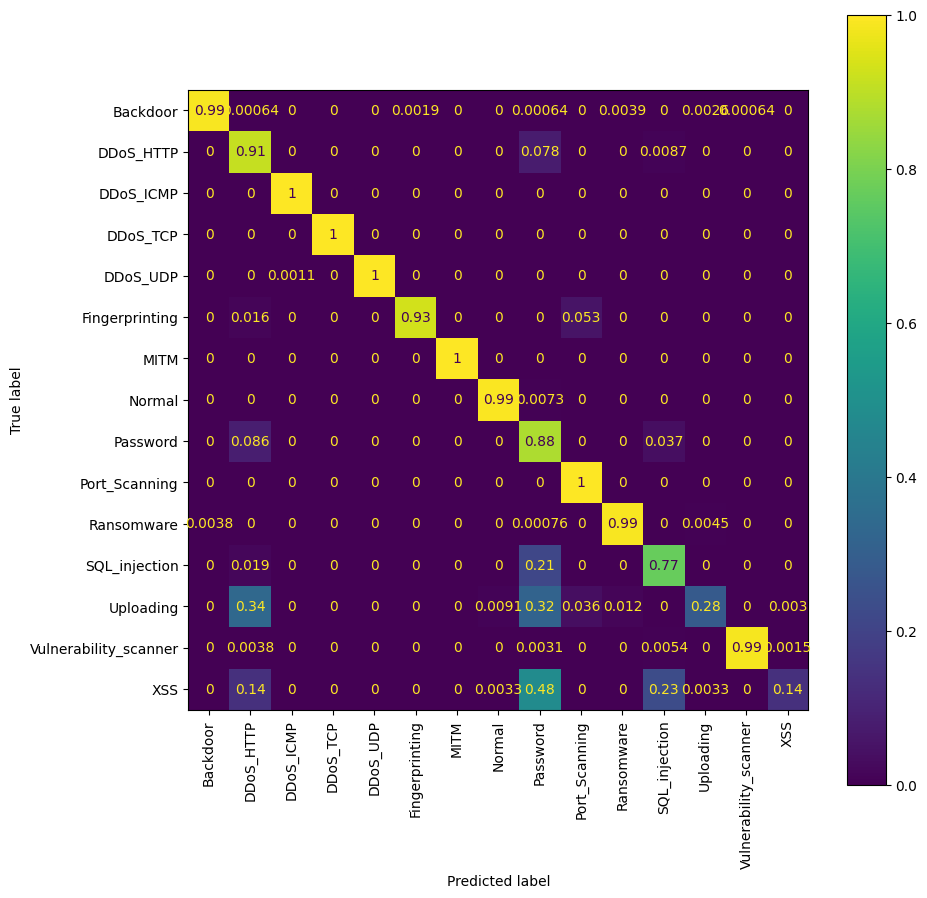

In [26]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
disp = metrics.ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred, normalize='true')
disp.ax_.set_xticklabels(LE.inverse_transform(rfc.classes_), rotation=90)
disp.ax_.set_yticklabels(LE.inverse_transform(rfc.classes_))
disp.figure_.set_size_inches(10, 10)


print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= rfc.classes_)
print(df_metric)
print("Labels: ", LE.inverse_transform(np.arange(15)))
print("classes: ", rfc.classes_)

## Feature Importance and selection

<Axes: >

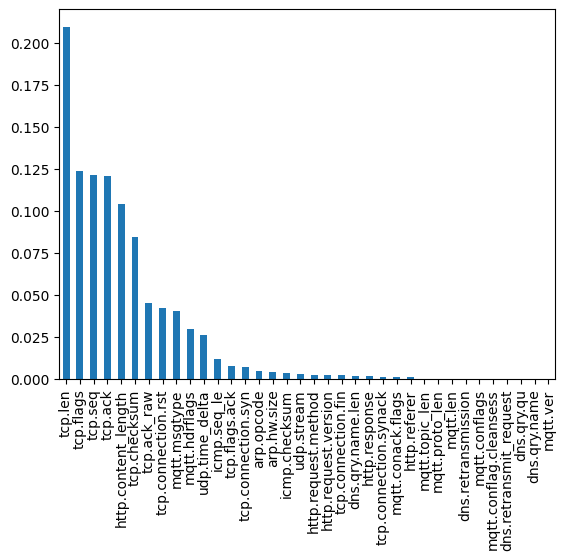

In [33]:
# Feature Importance 6 class
Feature_importance = pd.DataFrame(rfc.feature_importances_.flatten(), index=Dataset_std.columns).sort_values(by=0, ascending=False)
Feature_importance.plot(kind='bar', legend=False)

In [34]:
# Feature Selection
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(RandomForestClassifier(n_estimators=80, max_samples= 0.8, max_depth=11,
                      max_features= 0.9, criterion= 'gini', random_state=22, oob_score= True),
                      threshold= (0.1*max(Feature_importance[0]))).fit(X_train, Y_train) # 90% of the max importance = threshold
print("The threshold of importance: ", sfm.threshold_)
print("The selected Feature Names: ", Feature_importance.index[:sfm.get_support().sum()].to_list())
X_train_FS = sfm.transform(X_train)
X_test_FS = sfm.transform(X_test)

import pickle as pkl
pkl.dump(Feature_importance.index[:sfm.get_support().sum()].to_list(), open("Features_RFFS.pkl", "wb"))

The threshold of importance:  0.020941307015709693
The selected Feature Names:  ['tcp.len', 'tcp.flags', 'tcp.seq', 'tcp.ack', 'http.content_length', 'tcp.checksum', 'tcp.ack_raw', 'tcp.connection.rst', 'mqtt.msgtype', 'mqtt.hdrflags', 'udp.time_delta']


### Training and evaluating with selected features

Training Score:  0.9694835680751174
Test Score:  0.9605529112603508
Out of the Box Score:  0.9627021387584768


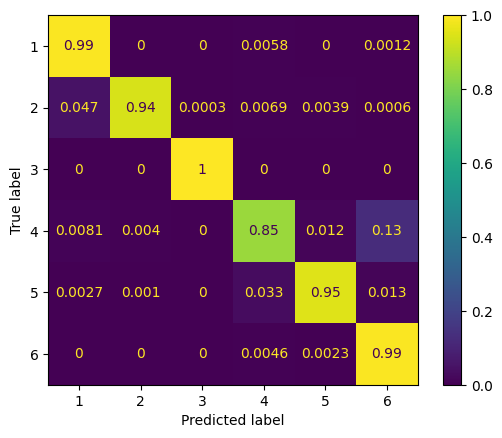

Average Accuracy: 0.9605529112603508
   Precision    Recall  F1-Score
1   0.948643  0.992975  0.970303
2   0.997119  0.941088  0.968293
3   0.999415  1.000000  0.999707
4   0.893542  0.848383  0.870377
5   0.986903  0.950887  0.968560
6   0.918425  0.993156  0.954330


In [43]:
rfc.fit(X_train_FS, Y_train)
Y_pred = rfc.predict(X_test_FS)
print("Training Score: ", rfc.score(X_train_FS, Y_train))
print("Test Score: ", rfc.score(X_test_FS, Y_test))
print("Out of the Box Score: ", rfc.oob_score_)

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=rfc.classes_, normalize= 'true')
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc.classes_)
disp.plot()
plt.show()

print("Average Accuracy:",metrics.accuracy_score(Y_test, Y_pred)) # Model Accuracy
df_metric = pd.DataFrame({'Precision':metrics.precision_score(Y_test, Y_pred, average=None),
                        'Recall': metrics.recall_score(Y_test, Y_pred, average=None),
                        'F1-Score': metrics.f1_score(Y_test, Y_pred, average=None)}, index= rfc.classes_)
print(df_metric)

## Conclusion

Random Forest is just an ensemble of decision trees.<br>
The modal have increased its accuracy after SMOTENN.(from 90% to 97%)<br>
The result of the Random Forest have a high accuracy rate. In 6 class classification the 4th Class (Malware Attacks) shows relatively little Precision, yet above 84% of recall and 89% of precision.<br>

The Feature selection based on RF feature importance showed that with only 11 Features the modal not only produced almost the same result but also reduced overfitting and computational time.<br>

The RF is also applied for 15 Class classification, where the modal produced an overall accuracy rate of 94%. The least Recall rate is 14% for XSS attacks whereas the second to least is at around 76% Recall, showing huge gap between their results.<br>  